In [1]:
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from growth.sweep.sweep import Sweep
from clones.visualization.settings import *
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
figsize = (2, 2)
savedir = '../../../figures/graphics/synthetic_example/'
savefig = lambda fig, name: fig.savefig(join(savedir, '{:s}.pdf'.format(name)), dpi=400, 
                                        rasterized=True, transparent=True, bbox_inches='tight')

# Generate synthetic data

Load simulated bleedthrough control experiment and generate synthetic fluorescence data. Synthetic images contain three color channels:
   - BLUE: Nuclear stain
   - RED: Clonal marker
   - GREEN: Control reporter

In [3]:
sweep = Sweep.load('../../../data/synthetic/sweeps/Sweep_181201_191516_local/')
simulation = sweep[20]

In [4]:
# generate synthetic data

measurement_kwargs = dict(measurement_noise=0.)
microscopy_kwargs = dict(bg_level=0.2, bg_noise=0.3)

microscopy = simulation.generate_microscopy(ambiguity=0.3, rho=0.0, bleedthrough=0.5, 
                measurement_kwargs=measurement_kwargs, microscopy_kwargs=microscopy_kwargs)

# save synthetic data
#np.save('../../../data/synthetic/new_annotation_example/image.npy', microscopy.im)
#microscopy.data.to_hdf('../../../data/synthetic/new_annotation_example/data.hdf', key='microscopy')

# load existing synthetic data
microscopy.im = np.load('../../../data/synthetic/new_annotation_example/image.npy')
microscopy.data = pd.read_hdf('../../../data/synthetic/new_annotation_example/data.hdf', key='microscopy')

nuclear_marker = microscopy[0]
clonal_marker = microscopy[1]
control_reporter = microscopy[2]

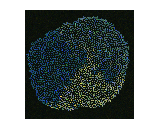

In [6]:
# render image of whole disc
fig = microscopy.render(size=2)
#savefig(fig, 'raw_image')

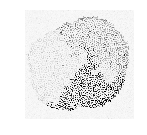

In [8]:
# render image of clonal marker
fig = clonal_marker.render(size=2, cmap=plt.cm.Greys)
#savefig(fig, 'clonal_marker')

# Segment synthetic nuclei

This is just a sanity check. We will perform the annotation using the ground-truth measurements. In principle we could also benchmark the accuracy of our segmentation and fluorescence measurements, but image segmentation is so context dependent that we don't feel this is a meaningful exercise.

In [9]:
from clones.data.images import ImageScalar
from clones.measurement.segmentation import Segmentation
from clones.measurement.measure import Measurements

def find_nuclei(im, show=False):
    
    # construct and preprocess image
    image = ImageScalar(im)
    image.preprocess(median_radius=1, gaussian_sigma=(0.5, 0.5))
    
    # perform segmentation and exclude small segments
    seg = Segmentation(image, seed_kws=dict(sigma=0.5, min_distance=1))
    seg.exclude_small_segments(min_area=10)
    
    if show:
        _ = image.show()
        
    return seg

In [10]:
# detect nuclei and measure their intensities
segmentation = find_nuclei(nuclear_marker.im_normalized[0], show=False)
measurements = Measurements(microscopy.rgb_im, segmentation.labels).build_dataframe()
print(segmentation.num_objects, nuclear_marker.num_nuclei)

2343 2374


# Assign labels to measurements

### Survey distribution of clonal marker levels

In [11]:
clonal_marker_levels = microscopy.data.clonal_marker.values

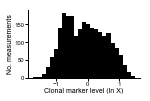

In [26]:
bins = 25

fig, ax = plt.subplots(figsize=(2, 1.25))
_ = ax.hist(np.log(clonal_marker_levels), bins=bins, color='k')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('No. measurements')
ax.set_xlabel('Clonal marker level (ln X)')

#savefig(fig, 'clonal_marker_histogram')

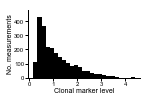

In [30]:
fig, ax = plt.subplots(figsize=(2, 1.25))
_ = ax.hist(clonal_marker_levels, bins=bins, color='k')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('No. measurements')
ax.set_xlabel('Clonal marker level')
ax.set_ylim(0, 480)

#savefig(fig, 'clonal_marker_histogram_linear')

### Construct weighted graph connecting adjacent measurements

In [31]:
from clones.annotation.spatial import WeightedGraph

In [32]:
graph = WeightedGraph(microscopy.data, weighted_by='clonal_marker', logratio=True)

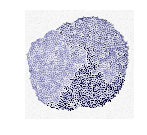

In [33]:
# create axis and add image
fig, ax = plt.subplots(figsize=figsize)
_ = clonal_marker.render(ax=ax, cmap=plt.cm.Greys)

# add graph
graph_kw = dict(node_size=0., node_color='navy', node_alpha=0., 
                edge_color='navy', lw=0.5, edge_alpha=0.5,
                colorby=None)

graph.show(ax=ax, **graph_kw)

#savefig(fig, 'graph')

### Generate samples

In [34]:
from clones.annotation.spatial.sampling import RadialSampler, CommunitySampler
from clones.annotation.spatial.correlation import CharacteristicLength
radial_sampler = RadialSampler(graph, 'clonal_marker', depth=1.)

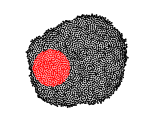

In [37]:
radial_sampler.plot_neigborhood(5, s=.5)

#savefig(plt.gcf(), 'radial_sampling')

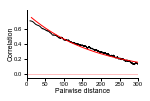

In [43]:
correlations = graph.get_correlations('clonal_marker')
correlations.visualize()
char = CharacteristicLength(correlations, fraction_of_max=.1)
ax = plt.gca()
char.plot_fit(ax=ax, color='r', lw=1)
ax.set_xlim(0, 300)
ax.set_ylim(-.05, 0.85)

#savefig(fig, 'spatial_correlation')

### Fit bivariate gaussian mixture model to clonal marker measurements

In [44]:
from clones.annotation import Annotation, BivariateModelSelection

In [47]:
annotator = Annotation('clonal_marker', sampler_type='radial', sampler_kwargs=dict(depth=1.), min_num_components=3, max_num_components=15)
selector = annotator.train(graph)

# save annotator and model selector
#annotator.save('../../../data/synthetic/annotation_example/', data=True)
#selector.save('../../../data/synthetic/annotation_example/')

'../../../data/synthetic/annotation_example/models'

In [48]:
# load annotator and selector
annotator = Annotation.load('../../../data/synthetic/annotation_example/')
selector = BivariateModelSelection.load('../../../data/synthetic/annotation_example/models')

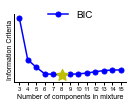

In [50]:
selector.plot_information_criteria(aic=False, figsize=(2, 1.25))

savefig(plt.gcf(), 'model_selection')

In [51]:
# get mixture model
mixture_model = selector.BIC_optimal

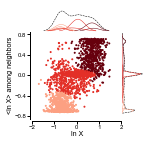

In [56]:
mixture_model.set_cmap(plt.cm.Reds, vmin=-1)
fig = mixture_model.plot_bivariate_data(s=1, cmap=plt.cm.Reds)

xlim = (-2., 2.)
fig.ax_joint.set_xlim(*xlim)
fig.ax_xmargin.set_xlim(*xlim)
fig.ax_joint.set_xticks([-2, -1, 0, 1, 2])

ylim = (-.85, .85)
_ = fig.ax_joint.set_ylim(*ylim)
_ = fig.ax_ymargin.set_ylim(*ylim)
_ = fig.ax_joint.set_yticks([-.8, -.4, 0, .4, .8])

#savefig(fig, 'bivariate_model')

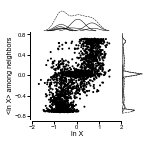

In [60]:
mixture_model.set_cmap(plt.cm.Greys, vmin=-2, vmax=0)
fig = mixture_model.plot_bivariate_data(s=1)

xlim = (-2., 2.)
fig.ax_joint.set_xlim(*xlim)
fig.ax_xmargin.set_xlim(*xlim)
fig.ax_joint.set_xticks([-2, -1, 0, 1, 2])

ylim = (-.85, .85)
_ = fig.ax_joint.set_ylim(*ylim)
_ = fig.ax_ymargin.set_ylim(*ylim)
_ = fig.ax_joint.set_yticks([-.8, -.4, 0, .4, .8])

#savefig(fig, 'bivariate_model_noclass')

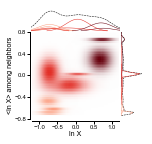

In [64]:
mixture_model.set_cmap(plt.cm.Reds, vmin=-1)
fig = mixture_model.plot_bivariate_pdf(cmap=plt.cm.Reds)

xlim = (-1.2, 1.2)
fig.ax_joint.set_xlim(*xlim)
fig.ax_xmargin.set_xlim(*xlim)
fig.ax_joint.set_xticks([-1, -.5, 0, .5, 1])

ylim = (-.8, 0.8)
_ = fig.ax_joint.set_ylim(*ylim)
_ = fig.ax_ymargin.set_ylim(*ylim)
_ = fig.ax_joint.set_yticks([-.8, -.4, 0, .4, .8])

fig.ax_joint.set_aspect(xlim[1]/ylim[1])

#savefig(fig, 'bivariate_model_pdfs')

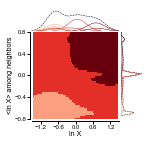

In [69]:
mixture_model.set_cmap(plt.cm.Reds, vmin=-1)
fig = mixture_model.plot_phase_space(cmap=plt.cm.Reds)

xlim = (-1.5, 1.5)
fig.ax_joint.set_xlim(*xlim)
fig.ax_xmargin.set_xlim(*xlim)
fig.ax_joint.set_xticks([-1.2, -.6, 0, .6, 1.2])

ylim = (-.8, 0.8)
fig.ax_joint.set_ylim(*ylim)
fig.ax_ymargin.set_ylim(*ylim)
fig.ax_joint.set_yticks([-.8, -.4, 0, .4, .8])

fig.ax_joint.set_aspect(xlim[1]/ylim[1])

#savefig(fig, 'bivariate_phase_map')

# Assess marginal projection

In [71]:
marginal_model = mixture_model[0]

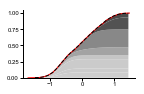

In [73]:
marginal_model.plot_cdfs(cmap=plt.cm.Greys, alpha=1., figsize=(2, 1.25))
from matplotlib.ticker import ScalarFormatter
ax = plt.gca()

#savefig(fig, 'marginal_fit_cdf')

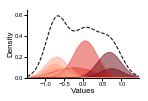

In [78]:
marginal_model.set_cmap(plt.cm.Reds, vmin=-1)
marginal_model.plot_pdfs(empirical=False, alpha=0.5, figsize=(2, 1.25))
ax = plt.gca()
ax.set_ylim(0, 0.65)

#savefig(fig, 'marginal_fit_pdf')

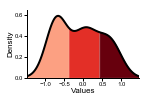

In [79]:
marginal_model.plot_pdf()
fig = plt.gcf()
fig.axes[0].set_ylim(0, .65)

#savefig(fig, 'marginal_fit_classifier_pdf')

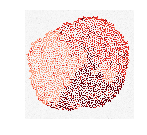

In [81]:
microscopy.data['label_marginal'] = marginal_model(microscopy.data)

fig, ax = plt.subplots(figsize=figsize)
clonal_marker.render(ax=ax, cmap=plt.cm.Greys)
microscopy.render_mask('label_marginal', cmap=plt.cm.Reds, vmin=-1, vmax=2, ax=ax)

#savefig(fig, 'classification_marginal')

0.83150800336984


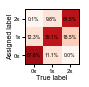

In [82]:
from clones.validation.scoring import Scoring
marginal_score = Scoring(microscopy.data.true_dosage, microscopy.data.label_marginal)
marginal_score.plot_matrix(text='rates', figsize=(1,1), fontsize=5)
print(marginal_score.percent_correct)

#savefig(marginal_score.matrix.fig, 'scores_marginal')

# Community annotation

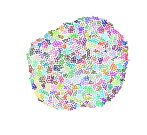

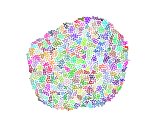

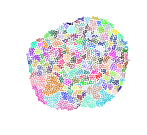

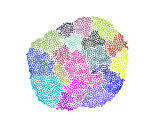

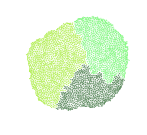

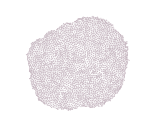

In [87]:
#graph.detect_communities()

for level in range(6):

    graph.assign_community(level)

    # create axis and add image
    fig, ax = plt.subplots(figsize=figsize)
    #_ = clonal_marker.render(ax=ax, cmap='r')
    clonal_marker.render_blank(ax=ax)

    # add graph
    graph_kw = dict(node_size=1., node_alpha=1., lw=0.5, edge_alpha=1., rasterized=True)
    graph.show(ax=ax, colorby='community', disconnect=True, node_color=None, edge_color=None, **graph_kw)

    savefig(fig, 'communities_{:d}'.format(level))

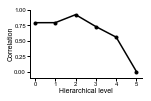

In [88]:
from clones.annotation.spatial.sampling import CommunitySampler
community_sampler = CommunitySampler(graph, 'clonal_marker', depth=1.)
community_sampler.plot_autocorrelation()
fig = plt.gcf()

savefig(fig, 'community_autocorrelation')

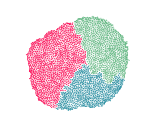

In [90]:
graph.assign_community(community_sampler.level)

# create axis and add image
fig, ax = plt.subplots(figsize=figsize)
#_ = clonal_marker.render(ax=ax, cmap='r')
clonal_marker.render_blank(ax=ax)

# add graph
graph_kw = dict(node_size=1., node_alpha=1., lw=0.5, edge_alpha=1.)
graph.show(ax=ax, colorby='community', disconnect=True, node_color=None, edge_color=None, **graph_kw)

#savefig(fig, 'communities_grouped')

In [91]:
microscopy.data['label_radial'] = annotator(graph)
microscopy.data['label_community'] = annotator(graph, sampler_type='community', sampler_kwargs=dict(depth=1.))

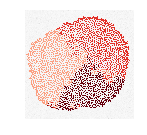

In [93]:
fig, ax = plt.subplots(figsize=figsize)
clonal_marker.render(ax=ax, cmap=plt.cm.Greys)
microscopy.render_mask('label_community', cmap=plt.cm.Reds, vmin=-1, vmax=2, ax=ax)

#savefig(fig, 'classification_community')

0.9507160909856782


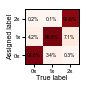

In [95]:
from clones.validation.scoring import Scoring

scoring_community = Scoring(microscopy.data.true_dosage, microscopy.data.label_community)
scoring_community.plot_matrix(text='rates', figsize=(1,1), fontsize=5)
print(scoring_community.percent_correct)

#savefig(scoring_community.matrix.fig, 'scores_community')

0.990849008642603


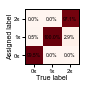

In [98]:
interior_pts = graph._mark_boundary('label_community')

interior = microscopy.data[interior_pts]

scoring_interior_community = Scoring(interior.true_dosage, interior.label_community)
scoring_interior_community.plot_matrix(text='rates', figsize=(1,1), fontsize=5)
print(scoring_interior_community.percent_correct)

#savefig(scoring_interior_community.matrix.fig, 'scores_community_interior')